# Setting up the environment

In [ ]:
#Setting up the environment and mounting the drive

import pandas as pd
import numpy as np
import io
from google.colab import drive
drive.mount('/content/drive')
import requests
import csv

!pip install selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import time
from selenium.common.exceptions import TimeoutException

from sklearn.feature_extraction.text import CountVectorizer

!pip install wordcloud
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

## All purpose
import pandas as pd 
import numpy as np

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

!pip install vaderSentiment
## NLP
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer
from gensim.summarization import keywords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# URL Crawler

In [ ]:
#You must run them in the same folder as the .py file
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', options=chrome_options)
defaultTimeout = 30
defaultRetryWaitTime = 0.5

url = 'https://www.tripadvisor.com.au/Hotels-g255073-Townsville_Queensland-Hotels.html'

#Creates a DataFrame for urls we can save later
hotels = pd.DataFrame(columns = ['url'])
hotels.index.name = "hotelId"

#stores the nextPage to parse
nextPage = url

def timedRetryGetAttribute(element, attribute):
    startTime = time.time()
    finishTime = startTime + defaultTimeout

    firstTime = True

    while time.time() < finishTime:
        try:
            if firstTime == False:
                time.sleep(defaultRetryWaitTime)
            firstTime = False
            attr = element.get_attribute(attribute)
            return attr
        except Exception:
            continue
    return ""

def getHotels(driver):
    hotelsNew = []
    
    listingTitles = WebDriverWait(driver, defaultTimeout).until(
        EC.presence_of_all_elements_located((By.CLASS_NAME, "listing_title"))
    )

    for titleElement in listingTitles:
        #Needed to catch exception as some titleElement were null
        try:
           childElements = WebDriverWait(titleElement, defaultTimeout).until(
                EC.presence_of_all_elements_located((By.XPATH, './/*'))
            )
        except TypeError:
            continue
        firstElement = childElements[0]

        hrefValue = timedRetryGetAttribute(firstElement, 'href')

        #Needed to catch exception as some values were null and showing as blank lines in the .csv
        try:
            if len(hrefValue) < 5:
                continue
        except TypeError:
            continue

        #Add the URL into our array that we'll save to CSV later
        hotelsNew.append(hrefValue)

    print(f"Found {len(hotelsNew)} hotels on this page")
    return hotelsNew

def getNextPage(driver, currentPageNumber):
    nextPageNumber = currentPageNumber + 1
    pageNumbersElement = WebDriverWait(driver, defaultTimeout).until(
        EC.presence_of_element_located((By.CLASS_NAME, "pageNumbers"))
    )
    pageNumbersElementChildren = WebDriverWait(pageNumbersElement, defaultTimeout).until(
        EC.presence_of_all_elements_located((By.XPATH, './/*'))
    )

    for child in pageNumbersElementChildren:
        pageNumberAttr = timedRetryGetAttribute(child, 'data-page-number')

        #Needed to catch exception as some values are null, such as "..." option
        try:
            pageNumberAttr = pageNumberAttr + ""
        except TypeError:
            continue

        if int(pageNumberAttr) == nextPageNumber:
            return timedRetryGetAttribute(child, 'href')
    return ""

#This tracks the current page number, useful for keeping track when moving through pages
#perhaps change to currentPageNumber?
currentPageNumber = 1

getPageRetryMax = 5
currentTry = 1

try:
    while nextPage != "":

        if currentTry > getPageRetryMax:
            raise Exception("Failed too many times")

        print(f"Downloading current page: {currentPageNumber}")
        driver.get(nextPage)

        print("Adding hotel URLs")
        hotelsNew = None
        try:
            hotelsNew = getHotels(driver)
        except Exception:
            currentTry = currentTry + 1
            continue

        print("Getting next page link")
        try:
            nextPage = getNextPage(driver, currentPageNumber)
        except Exception:
            currentTry = currentTry + 1
            continue

        for hotelNew in hotelsNew:
            hotels.loc[len(hotels)] = [hotelNew]

        currentPageNumber = currentPageNumber + 1
except Exception:
    print("Failed too many times")
finally:
    print("Saving data to disk")
    hotels.to_csv("hotelUrls.csv", index = True, header = True)
    driver.quit()

print("Program finished")

# Hotel Info Scraper

In [ ]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', options=chrome_options)
defaultTimeout = 30

hotelData = pd.read_csv('hotelUrls.csv')

totalHotelsToScrape = len(hotelData)
print(f"Preparing to scrape {totalHotelsToScrape} hotels")

hotelNames = []
hotelDescriptions = []

getPageRetryMax = 5
currentTry = 1

for index, row in hotelData.iterrows():
    currentTry = 1
    while True:

        if(currentTry > getPageRetryMax):
            print(f"Failed to retrieve information from hotel at index {index}, skipping")
            hotelNames.append("")
            hotelDescriptions.append("")
            break

        try:
            #There would be a nicer way to track this index, but this works
            currentHotelIndex = len(hotelNames)

            currentPageUrl = row['url']
            driver.get(currentPageUrl)

            #Get hotel name from page, it has an ID
            hotelNameElement = WebDriverWait(driver, defaultTimeout).until(
                EC.presence_of_element_located((By.ID, "HEADING"))
            )

            hotelName = hotelNameElement.text

            aboutElement = WebDriverWait(driver, defaultTimeout).until(
                EC.presence_of_element_located((By.ID, "ABOUT_TAB"))
            )

            descriptionElement = WebDriverWait(aboutElement, defaultTimeout).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='pIRBV _T']"))
            )

            descriptionText = descriptionElement.text.replace('\n', " ")

            #If the name is blank/small just put a blank string in the array to keep our column aligned with hotelData
            if(len(hotelName) < 5):
                hotelNames.append("")
            else:
                hotelNames.append(hotelName)

            #If the description is blank/small just put a blank string in the array to keep our column aligned with hotelData
            if(len(descriptionText) < 5):
                hotelDescriptions.append("")
            else:
                hotelDescriptions.append(descriptionText)

            print(f"Scraped hotel {currentHotelIndex + 1} of {totalHotelsToScrape}, hotelName: {hotelName}, len(descriptionText): {len(descriptionText)}")
            break
        except Exception:
            print(f"Failed to get data from page at index {index}, retrying...")
            currentTry = currentTry + 1
            continue

hotelData['hotelNames'] = hotelNames
hotelData['hotelDescriptions'] = hotelDescriptions

hotelData.to_csv("hotelData.csv", index = False, header = True)
driver.quit()

# Review Scraper


In [ ]:
#hotelId,reviewId,stars,date,review

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver', options=chrome_options)
defaultTimeout = 30
defaultRetryWaitTime = 0.5

hotelData = pd.read_csv('hotelUrls.csv')
hotelFlag = [0] * len(hotelData)
hotelData['hotelFlag'] = hotelFlag

hotelReviews = pd.DataFrame(columns = ['hotelId', 'reviewId', 'stars', 'date', 'review'])

def timedRetryGetAttribute(element, attribute):
    startTime = time.time()
    finishTime = startTime + defaultTimeout

    firstTime = True

    while time.time() < finishTime:
        try:
            if firstTime == False:
                time.sleep(defaultRetryWaitTime)
            firstTime = False
            attr = element.get_attribute(attribute)
            return attr
        except Exception:
            continue
    return ""

def timedRetryGetAttributeContains(element, attribute, contains):
    startTime = time.time()
    finishTime = startTime + defaultTimeout

    firstTime = True

    while time.time() < finishTime:
        try:
            if firstTime == False:
                time.sleep(defaultRetryWaitTime)
            firstTime = False
            attr = element.get_attribute(attribute)
            if("none" in attr):
                return attr
        except Exception:
            continue
    return ""

def timedRetryClickOnCssClass(element, cssClass):
    startTime = time.time()
    finishTime = startTime + defaultTimeout

    firstTime = True

    while time.time() < finishTime:
        try:
            if firstTime == False:
                time.sleep(defaultRetryWaitTime)
            firstTime = False

            elementClickable = WebDriverWait(element, defaultTimeout).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, cssClass))
            )
            elementClickable.click()
            return
        except Exception:
            continue
    return ""

def getReviews(dataFrameIndex, hotelId, pageUrl, pageNumber):
    #pageUrl = https://www.tripadvisor.com.au/Hotel_Review-g255073-d255393-Reviews-Hotel_Grand_Chancellor_Townsville-Townsville_Queensland.html#REVIEWS

    fixedUrl = pageUrl

    if pageNumber != 1:
        orNum = (pageNumber - 1) * 5
        reviewsKeyword = "Reviews-"
        reviewKeywordIndex = pageUrl.index(reviewsKeyword) + len(reviewsKeyword) #68
        urlFirstPart = pageUrl[:reviewKeywordIndex] #https://www.tripadvisor.com.au/Hotel_Review-g255073-d255393-Reviews-
        orStr = "or" + str(orNum) + "-" #or5-
        urlSecondPart = pageUrl[reviewKeywordIndex:] #Hotel_Grand_Chancellor_Townsville-Townsville_Queensland.html
        fixedUrl = urlFirstPart + orStr + urlSecondPart #https://www.tripadvisor.com.au/Hotel_Review-g255073-d255393-Reviews-or5-Hotel_Grand_Chancellor_Townsville-Townsville_Queensland.html

    getPageRetryMax = 5
    currentTry = 1

    while True:
        try:
            if(currentTry > getPageRetryMax):
                print(f"Failed to retrieve reviews from hotelId {hotelId}, skipping")
                break

            print(f"Scraping reviews for hotelId {hotelId} on their page number {pageNumber}")

            hotelReviewsNew = []

            driver.get(fixedUrl)

            try:
                reviewElements = WebDriverWait(driver, defaultTimeout).until(
                    EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div[class='cWwQK MC R2 Gi z Z BB dXjiy']"))
                )
            except TimeoutException:
                print(f"Could not see any reviews on hotelId {hotelId} on their {pageNumber} page")
                hotelData.loc[dataFrameIndex, 'hotelFlag'] = 1
                break

            #This will only trigger if a hotel has ZERO reviews in total
            if len(reviewElements) == 0:
                print(f"Hotel {hotelId} never had any reviews at all")
                hotelData.loc[dataFrameIndex, 'hotelFlag'] = 1
                return

            for idx, reviewElement in enumerate(reviewElements):
                #Get review id
                reviewId = (pageNumber - 1) * 5 + idx

                #Get review stars
                reviewStarParentElement = WebDriverWait(reviewElement, defaultTimeout).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='emWez F1']"))
                )

                reviewStarChildElement = WebDriverWait(reviewStarParentElement, defaultTimeout).until(
                    EC.presence_of_element_located((By.XPATH, './/*'))
                )

                reviewStarClass = timedRetryGetAttribute(reviewStarChildElement, "class") #ui_bubble_rating bubble_30
                reviewStars = reviewStarClass[-2:] #30

                #Get review date
                reviewDateElement = WebDriverWait(reviewElement, defaultTimeout).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "span[class='euPKI _R Me S4 H3']"))
                )

                reviewDateTextRaw = reviewDateElement.text #'Date of stay: November 2021'

                reviewDateTextRawColonIndex = reviewDateTextRaw.index(":") + len(":") + 1

                reviewDate = reviewDateTextRaw[reviewDateTextRawColonIndex:]

                #readMore
                reviewTextBlockElement = WebDriverWait(reviewElement, defaultTimeout).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='dovOW']"))
                )

                reviewTextBlockElementChildren = WebDriverWait(reviewTextBlockElement, defaultTimeout).until(
                    EC.presence_of_all_elements_located((By.XPATH, './*'))
                )

                for child in reviewTextBlockElementChildren:
                    childsClass = timedRetryGetAttribute(child, 'class')
                    if "duhwe _T bOlcm" not in childsClass:
                        continue
                    if "dMbup" in childsClass:
                        timedRetryClickOnCssClass(child, "span[class='eljVo _S Z']")
                        break

                #wait until the class 'duhwe _T bOlcm' is directly below dovOW, but dovOW refreshes as well
                expandedReviewTextBlockParentElement = WebDriverWait(reviewElement, defaultTimeout).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='dovOW']"))
                )

                try:
                    WebDriverWait(expandedReviewTextBlockParentElement, defaultTimeout).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='duhwe _T bOlcm']"))
                    )
                except Exception:
                    pass

                reviewTextElement = WebDriverWait(expandedReviewTextBlockParentElement, defaultTimeout).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "q[class='XllAv H4 _a']"))
                )

                reviewText = reviewTextElement.text.replace('\n', " ")

                hotelReviewsNew.append([hotelId, reviewId, reviewStars, reviewDate, reviewText])

            uiPaginationElement = None
            try:
                uiPaginationElement = WebDriverWait(driver, defaultTimeout).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='ui_pagination is-centered"))
                )
            except TimeoutException:
                hotelData.loc[dataFrameIndex, 'hotelFlag'] = 1
                print(f"Found {len(hotelReviewsNew)} new reviews for hotelId {hotelId}")
                print(f"Hotel {hotelId} only has one page of reviews")
                for hotelReviewNew in hotelReviewsNew:
                    hotelReviews.loc[len(hotelReviews)] = hotelReviewNew
                break

            uiPaginationElementChildren = WebDriverWait(uiPaginationElement, defaultTimeout).until(
                EC.presence_of_all_elements_located((By.XPATH, './*'))
            )

            for childElement in uiPaginationElementChildren:
                childElementClass = timedRetryGetAttribute(childElement, "class")
                isNextButton = "next" in childElementClass
                if isNextButton == False:
                    continue
                isNextDisabled = "disabled" in childElementClass
                if isNextDisabled == True:
                    print(f"Hotel {hotelId} does not have another page of reviews")
                    hotelData.loc[dataFrameIndex, 'hotelFlag'] = 1

            print(f"Found {len(hotelReviewsNew)} new reviews for hotelId {hotelId}")
            for hotelReviewNew in hotelReviewsNew:
                hotelReviews.loc[len(hotelReviews)] = hotelReviewNew
            break
        except Exception as error:
            print(f"Failed to retrieve reviews from hotelId {hotelId} on pageNumber {pageNumber}")
            currentTry = currentTry + 1


def getReviewsWithPageNumber(pageNumber):
    for index, row in hotelData.iterrows():
        hotelId = row['hotelId']
        pageUrl = row['url']
        hotelFlag = row['hotelFlag']
        if hotelFlag == 0:
            getReviews(index, hotelId, pageUrl, pageNumber)
            hotelReviews.to_csv("hotelReviews.csv", index = False, header = True)
            hotelData.to_csv("hotelReviews-flags.csv", index = False, header = True)

def anyHotelsToCheck():
    return 0 in hotelData['hotelFlag'].values

pageNumber = 1

while anyHotelsToCheck():
    print(f"Scraping each hotel page for reviews, looking at their page number {pageNumber}")
    getReviewsWithPageNumber(pageNumber)
    print(f"Finished scraping each hotel's page {pageNumber} for reviews, currently we have {len(hotelReviews)} reviews")
    pageNumber = pageNumber + 1

print("No more hotel reviews to scan")

driver.quit()

# Load dataframe



In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
dfHotelData = pd.read_csv("/content/drive/MyDrive/A3/hotelData.csv", dtype = object)

Mounted at /content/drive


In [ ]:
dfHotelData.head()

In [ ]:
len(dfHotelData)

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
dfHotelReviews = pd.read_csv("/content/drive/MyDrive/A3/hotelReviews.csv", dtype = object)

In [ ]:
dfHotelReviews.head()

# Harvested Corpus EDA (hotelData.csv)

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
dfHotelData = pd.read_csv("/content/drive/MyDrive/A3/hotelData.csv", dtype = object)

Mounted at /content/drive


In [ ]:
print(len(dfHotelData))

115
18242


### Data Wrangling

In [ ]:
# Check for missing hotel descriptions
dfHotelData.isna().sum()

hotelId               0
url                   0
hotelNames           25
hotelDescriptions    25
dtype: int64

In [ ]:
# Remove rows with missing descriptions
dfHotelData = dfHotelData.dropna( how='any',
                    subset=['hotelDescriptions'])

In [ ]:
len(dfHotelData)

90

### EDA of Hotel Description

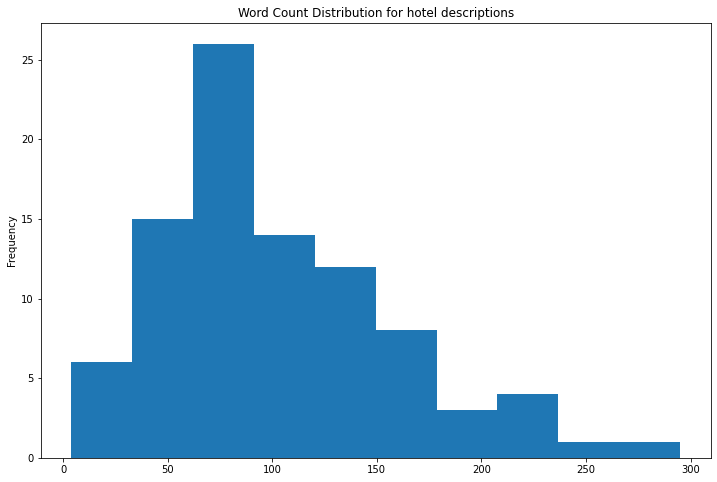

In [ ]:
# Calculating the word count for hotel description
dfHotelData['word_count'] = dfHotelData['hotelDescriptions'].apply(lambda x: len(str(x).split()))# Plotting the word count
word_count = dfHotelData['word_count'].plot(
    kind='hist',
    bins = 10,
    figsize = (12,8),
    title ='Word Count Distribution for hotel descriptions')

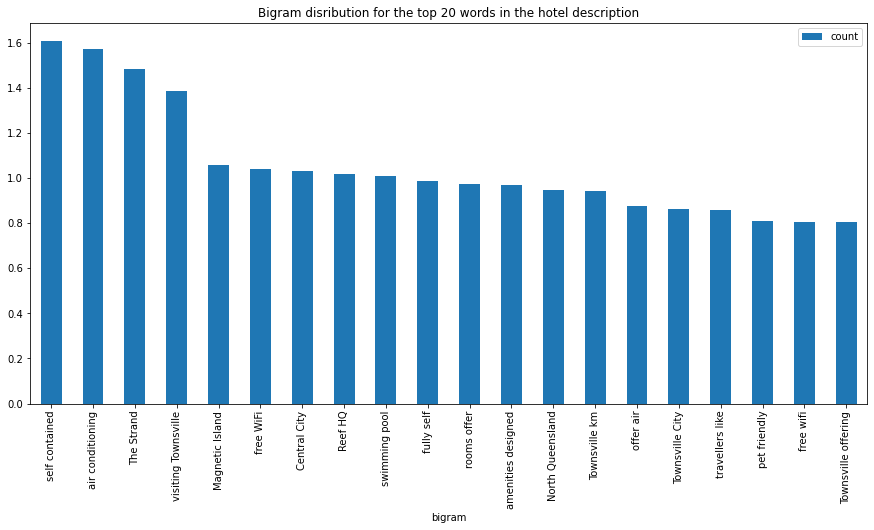

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Converting text descriptions into vectors using TF-IDF using Bigram
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(dfHotelData['hotelDescriptions'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
bigram = bigram.head(20)

#Plotting the bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the hotel description", figsize = (15,7), )

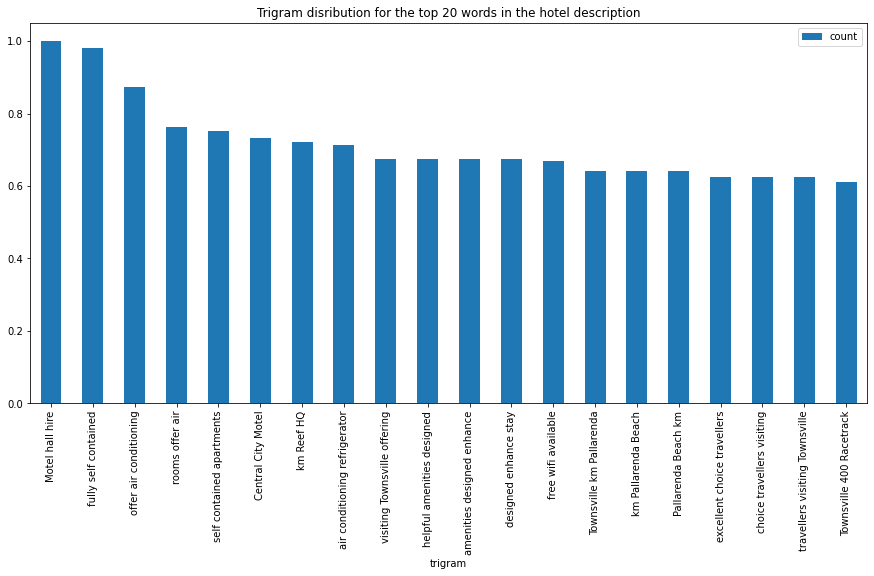

In [ ]:
#Converting text descriptions into vectors using TF-IDF using Trigram
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(dfHotelData['hotelDescriptions'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)#converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
trigram = trigram.head(20)

#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Trigram disribution for the top 20 words in the hotel description", figsize = (15,7), )

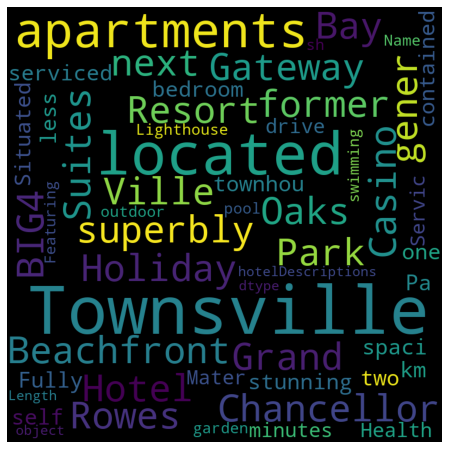

In [ ]:
# Word cloud

wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', max_words = 1000
                      , min_font_size = 20).generate(str(dfHotelData['hotelDescriptions']))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Harvested Corpus EDA (hotelReviews.csv)

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
dfHotelReviews = pd.read_csv("/content/drive/MyDrive/A3/hotelReviews.csv", dtype = object)

Mounted at /content/drive


In [ ]:
dfHotelReviews.head(50)

### Data Wrangling

In [ ]:
# Check for missing hotel reviews
dfHotelReviews.isna().sum()

In [ ]:
len(dfHotelReviews)

18242

In [ ]:
# Change stars rating 
dfHotelReviews['stars'].replace({'50': '5', '40': '4', '30': '3', '20': '2', '10': '1'}, inplace = True)

### EDA of Hotel Reviews

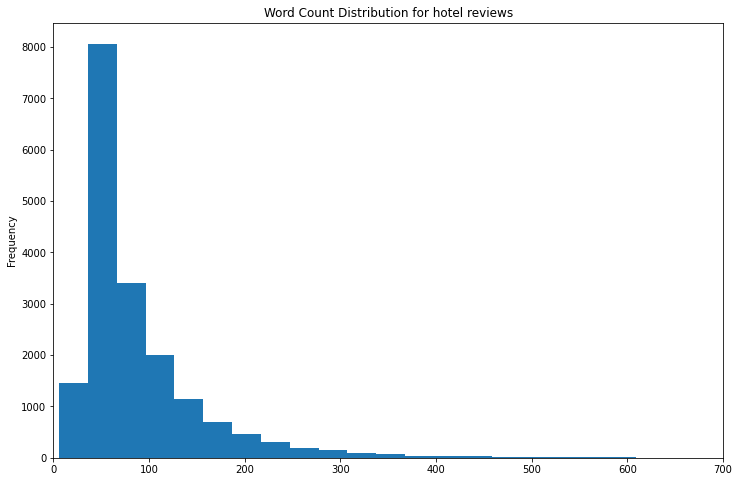

In [ ]:
# Calculating the word count for hotel description
dfHotelReviews['word_count'] = dfHotelReviews['review'].apply(lambda x: len(str(x).split()))# Plotting the word count
word_count = dfHotelReviews['word_count'].plot(
    kind = 'hist',
    bins = 50,
    figsize = (12,8),
    xlim = (0,700),
    title = 'Word Count Distribution for hotel reviews')

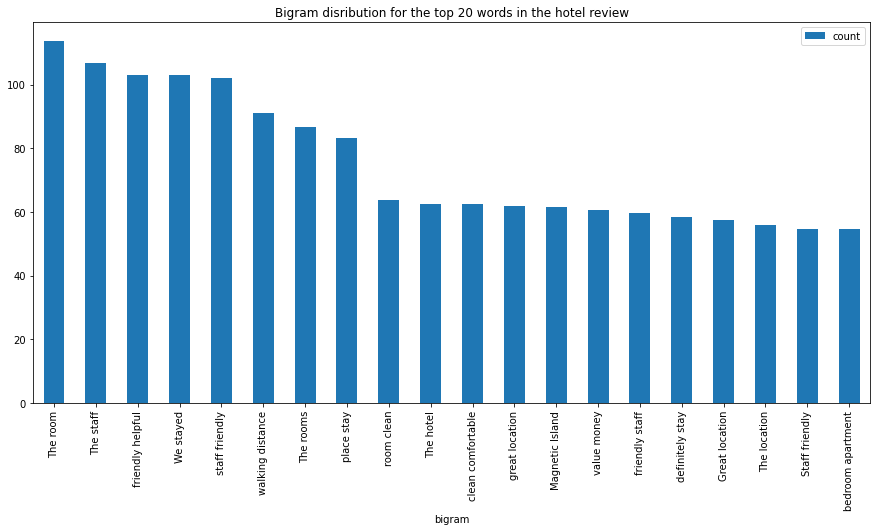

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Converting text descriptions into vectors using TF-IDF using Bigram
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(dfHotelReviews['review'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)
#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
bigram = bigram.head(20)

#Plotting the bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the hotel review", figsize = (15,7), )

In [ ]:
#Converting text descriptions into vectors using TF-IDF using Trigram
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(dfHotelReviews['review'])
total_words = tfidf_matrix.sum(axis=0) 
#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)#converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 
#Taking first 20 records
trigram = trigram.head(20)

#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Trigram disribution for the top 20 words in the hotel review", figsize = (15,7), )

In [ ]:
# HotelId distribution plot for all data
dist_plot = dfHotelReviews['hotelId'].value_counts().plot(x = 'hotelId', y ='count', kind = 'bar', figsize = (10,5))


In [ ]:
# Date of stay distribution plot for all data
dist_plot = dfHotelReviews['date'].value_counts().plot(x = 'date', y ='count', kind = 'bar', figsize = (10,5))


In [ ]:
# Date of stay distribution plot for all data
dist_plot = dfHotelReviews['stars'].value_counts().plot(x = 'date', y ='count', kind = 'bar', title = "Disribution of the ratings in hotel review", figsize = (10,5))


In [ ]:
# Word cloud

wordcloud = WordCloud(width = 800, height = 800, background_color = 'black', max_words = 1000
                      , min_font_size = 20).generate(str(dfHotelReviews['review']))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# NLP Task 1: Topic Modelling

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
df = pd.read_csv("/content/drive/MyDrive/A3/hotelReviews.csv", dtype = object)

In [ ]:
!pip install pyLDAvis

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
# Convert to list
data = df.review.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

In [ ]:
def sentToWords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sentToWords(data))

print(data_words[:1])

In [ ]:
# Create bigram and trigram
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def removeStopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def makeBigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def makeTrigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = removeStopwords(data_words)

# Form Bigrams
data_words_bigrams = makeBigrams(data_words_nostops)

nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
!pip install pyLDAvis.gensim_models
import pyLDAvis.gensim_models

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

# NLP Task 2: Sentiment Analysis

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
dfHotelReviews = pd.read_csv("/content/drive/MyDrive/A3/hotelReviews.csv", dtype = object)

Mounted at /content/drive


In [ ]:
## Creating sentimental polarity 
analyzer = SentimentIntensityAnalyzer()
def compound_score(txt):
    return analyzer.polarity_scores(txt)["compound"]

## Sentiments
def sentiment(score):
    emotion = ""
    if score >= 0.5:
        emotion = "Positive"
    elif score <= -0.5:
        emotion = "Negative"
    else:
        emotion = "Neutral"
    return emotion

In [ ]:
## Importing CSV file
df = dfHotelReviews

## Applying Compund score
polarity_scores = df["review"].astype("str").apply(compound_score)
df["Sentiment_Score"] = polarity_scores

## Applying Sentiment
df["Sentiment"] = df["Sentiment_Score"].apply(sentiment)

In [ ]:
# Change stars rating 
df['stars'].replace({'50': '5', '40': '4', '30': '3', '20': '2', '10': '1'}, inplace = True)

In [ ]:
df.Sentiment.value_counts()

Positive    15820
Neutral      1362
Negative     1060
Name: Sentiment, dtype: int64

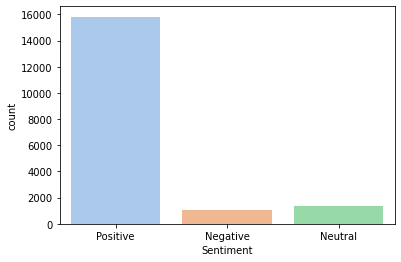

In [ ]:
sns.countplot(data=df,x="Sentiment",palette="pastel");

In [ ]:
df.head()

In [ ]:
# Function to retrieve top few number of each category
def get_top_data(top_n = 1000):
    top_data_df_positive = df[df['Sentiment'] == 'Positive'].head(top_n)
    top_data_df_negative = df[df['Sentiment'] == 'Negative'].head(top_n)
    top_data_df_neutral = df[df['Sentiment'] == 'Neutral'].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative, top_data_df_neutral])
    return top_data_df_small

# Function call to get the top 1000 from each sentiment
df = get_top_data(top_n=1000)

# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(df['Sentiment'].value_counts())
df.head(10)

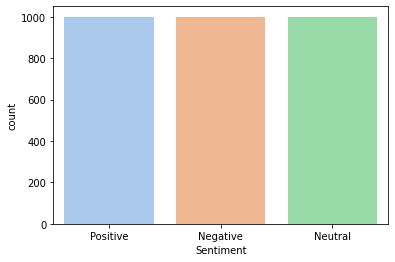

In [ ]:
sns.countplot(data=df,x="Sentiment",palette="pastel");

In [ ]:

# Preparing data for visualization 
Viz_1 = df[['stars','Sentiment']].value_counts().rename_axis(['stars','Sentiment']).reset_index(name='counts')

# Plotting the Bar Graph 
fig = px.bar(x=Viz_1.stars, y=Viz_1.counts, color=Viz_1.Sentiment,color_discrete_sequence=px.colors.qualitative.Pastel,title="Sentiment & Ratings",labels={'x':'stars','y':'Total Number'})
fig.show()

In [ ]:
#Viz2 Data preparation 
Viz_2 = df['stars'].value_counts().rename_axis(['stars']).reset_index(name='counts')
    
# Plotting  pie chart for ratings
fig_pie = px.pie(values=Viz_2.counts, names=Viz_2.stars, title='Rating Distribution of the data',color_discrete_sequence=px.colors.qualitative.Pastel)
fig_pie.show()

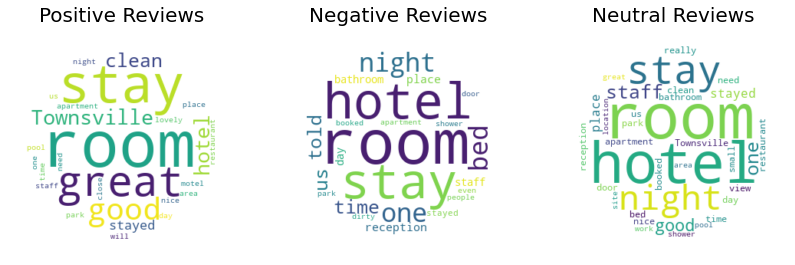

In [ ]:
# Getting all the reviews termed positive in a single string and forming a word cloud of the string
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[14, 14], facecolor = None)

text1 =''
for i in df[df['Sentiment']=='Positive']['review'].values:
    text1+=i + ' '

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc1 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc1.generate(text1)

ax1.axis("off")
ax1.imshow(wc1, interpolation="bilinear")
ax1.set_title('Positive Reviews',fontsize=20);

text2 =''
for i in df[df['Sentiment']=='Negative']['review'].values:
    text2+=i + ' '

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)


wc2 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc2.generate(text2)

ax2.axis("off")
ax2.imshow(wc2, interpolation="bilinear")
ax2.set_title('Negative Reviews',fontsize=20);

text3 =''
for i in df[df['Sentiment']=='Neutral']['review'].values:
    text3+=i + ' '

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc3 = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True, mask=mask)
wc3.generate(text3)

ax3.axis("off")
ax3.imshow(wc3, interpolation="bilinear")
ax3.set_title('Neutral Reviews',fontsize=20);

plt.show()

In [ ]:
df["keywords"] = df["review"].apply(keywords)
df["keywords"] = df["keywords"].astype("str").str.replace('\n',',') 

In [ ]:
words = []
for x in df.keywords.values:
    x=x.split(",")
    for i in x:
        words.append(i)

In [ ]:
from collections import Counter
word_counter = Counter(words)

In [ ]:
# Python Counter
word_df = pd.DataFrame(np.array(list(word_counter.items())),columns=["keyword","count"])

In [ ]:
# Top ten keywords
word_df["count"] = word_df["count"].astype(int)
word_df = word_df.sort_values(['count'], ascending=False)
top_10 = word_df[0:10]
word_df.head(10)

,keyword,count
1,room,311
77,rooms,164
7,great,148
73,good,113
92,staff,113
103,hotel,105
2,stay,104
162,park,100
6,,88
135,parking,81


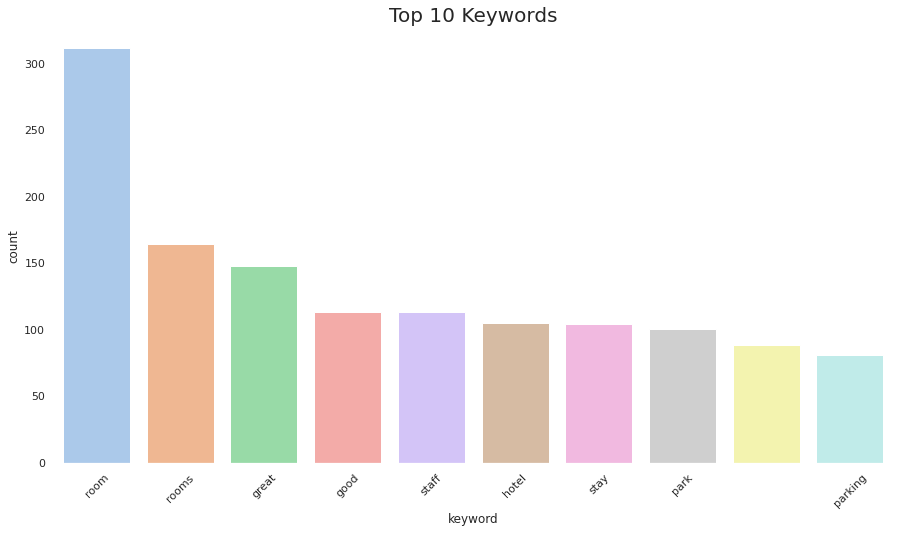

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
fig, ax = plt.subplots()

ax = sns.barplot(data=top_10,x="keyword",y="count",palette="pastel")
ax.patch.set_visible(False)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_title("Top 10 Keywords",fontsize=20);

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
words = ["hotel","room","rooms","hotels"]
for x in words:
    df["review"] = df["review"].astype(str).str.replace(x,"")

In [ ]:
# Tokenisation

from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
df['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in df['review']] 
print(df['tokenized_text'].head(10))

0     [just, overnight, and, breakfast, the, breakfa...
1     [great, stay, and, fantastic, view, the, staff...
2     [central, and, able, to, walk, to, most, thing...
3     [was, there, for, work, it, was, close, to, ev...
4     [the, was, very, clean, great, location, close...
6     [booked, nights, in, deluxe, suite, ocean, vie...
7     [before, they, turned, the, palm, house, to, t...
8     [amazing, with, amazing, team, members, very, ...
9     [the, quarterdeck, bar, is, great, setting, ov...
11    [it, was, pleasurable, stay, and, short, walk,...
Name: tokenized_text, dtype: object


In [ ]:
# Stemming

from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Get the stemmed_tokens
df['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in df['tokenized_text'] ]
df['stemmed_tokens'].head(10)

0     [just, overnight, and, breakfast, the, breakfa...
1     [great, stai, and, fantast, view, the, staff, ...
2     [central, and, abl, to, walk, to, most, thing,...
3     [wa, there, for, work, it, wa, close, to, ever...
4     [the, wa, veri, clean, great, locat, close, to...
6     [book, night, in, delux, suit, ocean, view, th...
7     [befor, thei, turn, the, palm, hous, to, the, ...
8     [amaz, with, amaz, team, member, veri, friendl...
9     [the, quarterdeck, bar, is, great, set, overlo...
11    [it, wa, pleasur, stai, and, short, walk, to, ...
Name: stemmed_tokens, dtype: object

In [ ]:
# Building a dictionary

from gensim import corpora
# Build the dictionary
mydict = corpora.Dictionary(df['stemmed_tokens'])
print("Total unique words:")
print(len(mydict.token2id))
print("\nSample data from dictionary:")
i = 0
# Print top 4 (word, id) tuples
for key in mydict.token2id.keys():
    print("Word: {} - ID: {} ".format(key, mydict.token2id[key]))
    if i == 3:
        break
    i += 1

Total unique words:
7156

Sample data from dictionary:
Word: across - ID: 0 
Word: and - ID: 1 
Word: breakfast - ID: 2 
Word: choic - ID: 3 


In [ ]:
# Splitting into train and test sets

from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(df, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df[['stars', 'stemmed_tokens']], 
                                                        df['Sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
Neutral     707
Negative    700
Positive    693
Name: Sentiment, dtype: int64
Value counts for Test sentiments
Positive    307
Negative    300
Neutral     293
Name: Sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index stars                                     stemmed_tokens
0  12648     2  [we, have, visit, casino, in, sydnei, gold, co...
1   5044     2  [hard, to, find, on, the, strand, for, easter,...
2    865     5  [the, locat, is, perfect, the, price, is, veri...
3    826     5  [thi, properti, ha, everyth, go, for, it, and,...
4   3756     5  [have, stai, in, mani, of, the, motel, in, the...


In [ ]:
# Created TFIDF model

# Train the tfidf Model 
from gensim.models import TfidfModel
# Make sure the dictionary is created from the previous block
# BOW corpus is required for tfidf model
corpus = [mydict.doc2bow(line) for line in df['stemmed_tokens']]

# TF-IDF Model
tfidf_model = TfidfModel(corpus)

In [ ]:
# Generating TFIDF vectors

import gensim
import time
start_time = time.time()
OUTPUT_FOLDER = '/content/drive/My Drive/A3/'

tfidf_filename = OUTPUT_FOLDER + 'train_review_tfidf.csv'
# Storing the tfidf vectors for training data in a file
vocab_len = len(mydict.token2id)
with open(tfidf_filename, 'w+') as tfidf_file:
    for index, row in X_train.iterrows():
        doc = mydict.doc2bow(row['stemmed_tokens'])
        features = gensim.matutils.corpus2csc([tfidf_model[doc]], num_terms=vocab_len).toarray()[:,0]
        if index == 0:
            header = ",".join(str(mydict[ele]) for ele in range(vocab_len))
            print(header)
            print(tfidf_model[doc])
            tfidf_file.write(header)
            tfidf_file.write("\n")
        line1 = ",".join( [str(vector_element) for vector_element in features] )
        tfidf_file.write(line1)
        tfidf_file.write('\n')
print("Time taken to create tfidf for :" + str(time.time() - start_time))

across,and,breakfast,choic,cowboi,for,from,here,hungri,icecream,if,is,it,just,late,lot,mani,night,of,on,other,out,overnight,road,short,so,straight,that,the,walk,worth,you,ar,back,be,best,but,cbd,clean,could,fantast,great,help,in,kept,longer,next,nice,staff,stai,time,to,townsvil,try,view,wa,well,will,wish,abl,all,balconi,book,can,central,cours,delici,friendli,had,meal,most,onlin,room,small,spaciou,thing,two,valu,with,again,close,comfort,definit,everyth,found,plu,restaur,steak,there,top,travel,when,work,cafe,club,down,footbal,good,locat,market,morn,stair,sundai,veri,abism,accomod,adult,also,area,art,as,aswel,at,bar,bath,black,bottom,budget,by,cannot,carpet,ceil,children,christma,come,commerci,compar,constantli,coupl,cover,crack,cram,crowd,damag,delux,desir,dine,discov,dj,don,door,equip,floor,forget,foyer,free,full,garag,get,glass,go,got,gym,ha,hallwai,have,hear,high,hous,idea,incent,inebri,lack,last,leak,leav,licens,light,like,local,long,look,lower,machin,minut,mould,my,navig,nil,not,not

In [ ]:
# Training sentiment classification model using tfidf vectors

from sklearn.tree import DecisionTreeClassifier
import time
start_time = time.time()

# Read the TFIDF vectors
tfidf_df = pd.read_csv('/content/drive/My Drive/A3/train_review_tfidf.csv')

# Initialize the model
clf_decision_tfidf = DecisionTreeClassifier(random_state=2)

# Fit the model 
clf_decision_tfidf.fit(tfidf_df, Y_train['Sentiment'])
print("Time to taken to fit the TF-IDF as input for classifier: " + str(time.time() - start_time))


Time to taken to fit the TF-IDF as input for classifier: 4.550311326980591


In [ ]:
# Find out the most important features from the tfidf classification model

importances = list(clf_decision_tfidf.feature_importances_)
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(tfidf_df.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# print(feature_importances)
top_i = 0
for pair in feature_importances:
    print('Variable: {:10} Importance: {}'.format(*pair))
    if top_i == 10:
        break
    top_i += 1

Variable: not        Importance: 0.0743225813
Variable: love       Importance: 0.037668821
Variable: friendli   Importance: 0.0375842673
Variable: great      Importance: 0.0375575124
Variable: no         Importance: 0.0280894298
Variable: comfort    Importance: 0.0216480563
Variable: and        Importance: 0.0196681452
Variable: locat      Importance: 0.0147433007
Variable: on         Importance: 0.0144248843
Variable: the        Importance: 0.0128809058
Variable: recommend  Importance: 0.0125819778


In [ ]:
# Testing the model

from sklearn.metrics import classification_report
test_features_tfidf = []
import time
start_time = time.time()
for index, row in X_test.iterrows():
    doc = mydict.doc2bow(row['stemmed_tokens'])
    features = gensim.matutils.corpus2csc([tfidf_model[doc]], num_terms=vocab_len).toarray()[:,0]
    test_features_tfidf.append(features)
test_predictions_tfidf = clf_decision_tfidf.predict(test_features_tfidf)
print(classification_report(Y_test['Sentiment'],test_predictions_tfidf))
print("Time taken to predict using TF-IDF:" + str(time.time() - start_time))

              precision    recall  f1-score   support

    Negative       0.56      0.55      0.55       300
     Neutral       0.44      0.44      0.44       293
    Positive       0.68      0.69      0.68       307

    accuracy                           0.56       900
   macro avg       0.56      0.56      0.56       900
weighted avg       0.56      0.56      0.56       900

Time taken to predict using TF-IDF:0.8248293399810791


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names

